In [71]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [72]:
tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def load_data(train_data, test_data, num_words=10000):
    # data를 train~
    train_data.drop_duplicates('document', inplace=True)  # duplication! 재거
    train_data = train_data.dropna()  # 결측치 제거 - axis=0 NaN인 행을 제거
    X_train = []
    for sentence in train_data['document']:
        tmp = tokenizer.morphs(sentence)  # 토큰화
        tmp = [word for word in tmp if word not in stopwords]  # 불용어 제거
        X_train.append(tmp)

    # test data
    test_data.drop_duplicates('document', inplace=True)  # 중복 제거
    test_data = test_data.dropna()  # 결측치 제거 - axis=0 NaN인 행을 제거
    X_test = []
    for sentence in test_data['document']:
        tmp = tokenizer.morphs(sentence)  # 토큰화
        tmp = [word for word in tmp if word not in stopwords]  # 불용어 제거
        X_test.append(tmp)

    # word_to_index 구성
    words = list(np.concatenate(X_train))
    counter = Counter(words)  # length - 53,961
    counter = counter.most_common(num_words - 4)  # 가장 자주 사용되는 단어 순으로 정렬되어 형변환
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # length - 10,000
    word_to_index = {word: index for index, word in enumerate(vocab)}  # 형태 - {'the': 4}

    # 텍스트로 이루어진 리스트를 인덱스리스트로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))

    return X_train, y_train, X_test, y_test, word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index: word for word, index in word_to_index.items()}


# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word
                                       in sentence.split()]

In [73]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in
                    encoded_sentence[1:])
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]



In [74]:
# 3. 모델구성을 위한 데이터 분석 및 가공
# 3-1. maxlen(문장 최대 길이) 값 찾아내기
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]  # 각각의 문장 길이를 담은 배열 생성
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))    # 15.969376315021577
print('문장길이 최대 : ', np.max(num_tokens))     # 116
print('문장길이 표준편차 : ', np.std(num_tokens))  # 12.843535456326455

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)  # 41
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다.')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다.


In [75]:
# 3-2. padding 설정
x_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
print(x_train.shape, x_test.shape)  # (146182, 41) (49157, 41)


(146182, 41) (49157, 41)


In [76]:
# 3-3. train set & valid set 분리
x_val = x_train[:40000]
y_val = y_train[:40000]
x_train = x_train[40000:]
y_train = y_train[40000:]

print(x_train[0])
print(len(x_train))

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   58  821 1695 6141    5  942   65   37]
106182


In [77]:
# 4. 모델구성 및 훈련

vocab_size = 10000    
word_vector_dim = 16  

In [78]:
# LSTM - loss: 0.3679 - accuracy: 0.8414
def model_1():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.LSTM(8))   # LSTM state 벡터의 차원수는 8로 하였습니다! 이게 맞나..
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 긍정/부정?
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history


In [79]:
# 4-2. Conv1D loss: 0.3563 - accuracy: 0.8471으로 추정된다!
def model_2():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history

In [81]:
# 4-3. GlobalMaxPooling1D loss: 0.3631 - accuracy: 0.8403!!
def model_3():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history

model, history = model_3()

Epoch 1/3
208/208 [==============================] - 2s 7ms/step - loss: 0.6675 - accuracy: 0.6124 - val_loss: 0.5132 - val_accuracy: 0.8063
Epoch 2/3
208/208 [==============================] - 1s 6ms/step - loss: 0.4649 - accuracy: 0.8251 - val_loss: 0.3879 - val_accuracy: 0.8365
Epoch 3/3
208/208 [==============================] - 1s 6ms/step - loss: 0.3525 - accuracy: 0.8580 - val_loss: 0.3591 - val_accuracy: 0.8433


In [82]:
results = model.evaluate(x_test,  y_test, verbose=2)
print(f'result :{results}')

1537/1537 - 2s - loss: 0.3688 - accuracy: 0.8378
result :[0.36881521344184875, 0.8378257155418396]


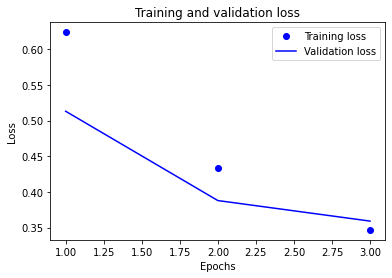

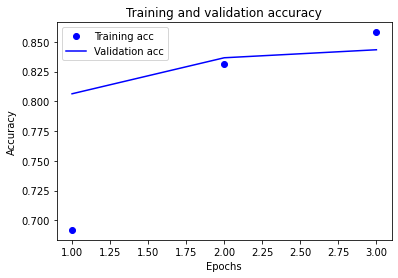

In [83]:
def check_training_n_validation_loss(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')  # 파란색 점
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 파란 실선
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()   # 그림 초기화

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


check_training_n_validation_loss(history)